## Machine learining con Python i Scikit-learn

Python és un del llenguatges de programació que domina dins l'àmbit de machine learning. Scikit-learn és una llibreria de codi obert que unifica sota un unic marc els principals algoritmes i funcions, facilitant les etapes de preprocessat, entrenament, optimització i validació dels models. 

Llibreries utilitzades:

In [1]:
#Tractament de dades 
import numpy as np
import pandas as pd
from tabulate import tabulate

#Gràfics
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

# Preprocessat i model

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import optuna

# Altres
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

ModuleNotFoundError: No module named 'tabulate'

In [19]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Gráficos

import matplotlib.pyplot as plt

# Preprocesado y modelado

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


#Importing Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


In [3]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

## Dades

In [4]:
#Importem el dataset i el preparem. El dataset conté els ECNumbers de 5221 reaccions químiques a més de 6 variables adicionals.
input="data/R_w_D_T.csv"

df = pd.read_csv(input, sep=",")
eliminar=["SabioReactionID","1","2","3","4","10","11","25","18","19","26","14","15","29","30", "23", "24", "27", "28", "31", "32", "5","7", "13", "14", "20", "22", "28", "21" ]
df = df.drop(eliminar, axis=1)
df = df.dropna()

def modificar_valor(valor):
    if pd.isna(valor):  # Verificar si el valor es NaN
        return valor  # Devolver NaN sin modificar
    numeros = valor.split('.')  # Separar los números por el punto
    primer_numero = int(numeros[0])  # Obtener el primer número
    return str(primer_numero)  # Devolver el primer número como string


# Aplicar la función a la columna 'ECNumber' utilizando el método 'apply'
df['ECNumber'] = df['ECNumber'].apply(modificar_valor)
new_columns = [ "Balaband J", "H bond acceptor", "H bond donor", 'MW', 'TPSA','logP',"ECNumber"]
df.columns = new_columns

df.to_csv("data/RF.csv", index=False)

L'objectiu és obtenir un model capaç de predir l'ECNumber de la reacció.

## Anàlisis exploratori

Abans d'entrenar un model predictiu, és molt important realitzar una eploració descriptiva del conjunt de dades. Aquest procés permet entendre millor la informació que conté cada variable, així com detectar possibles error. 

In [5]:
input="data/RF.csv"
df = pd.read_csv(input, sep=",")
df.head(4)

,Balaband J,H bond acceptor,H bond donor,MW,TPSA,logP,ECNumber
0,2.572326,7.0,6.0,260.029719,156.91,-3.10440,5
1,4.302611,21.0,13.0,767.025464,436.04,-5.54083,2
2,2.674029,8.0,7.0,339.996049,203.44,-2.98580,4
3,3.550749,4.0,3.0,169.998025,104.06,-1.34450,5


# Tipo de cada columna

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5220 entries, 0 to 5219
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Balaband J       5220 non-null   float64
 1   H bond acceptor  5220 non-null   float64
 2   H bond donor     5220 non-null   float64
 3   MW               5220 non-null   float64
 4   TPSA             5220 non-null   float64
 5   logP             5220 non-null   float64
 6   ECNumber         5220 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 285.6 KB


Totes les columnes són del tipus adequat.

# Nombre d'observacions i valos NaN

És basic coneixer el nombre d'observacions disponibles i si totes elles estan completes. Els valors nuls són molt importants, ja que la majoria d'algoritmes no accepten observacions incompletes o bé es veuen molt infuenciats en cas que en tinguin. És per això que el següent pas és identificar si el dataset conté valors Nan.

In [7]:
df.shape

(5220, 7)

In [8]:
df.isna().sum().sort_values()

Balaband J         0
H bond acceptor    0
H bond donor       0
MW                 0
TPSA               0
logP               0
ECNumber           0
dtype: int64

Cap variable conté valors nuls. 

# Variable Resposta

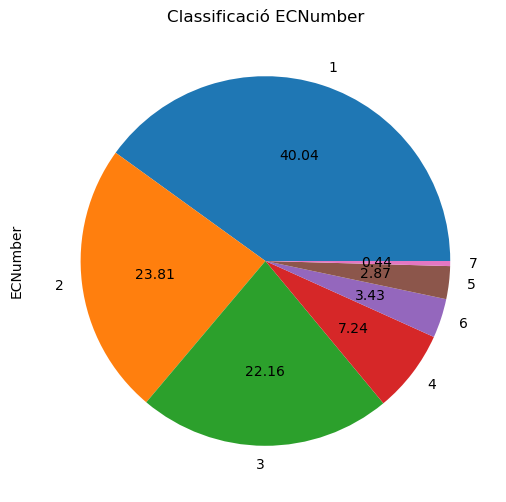

In [9]:
plot = df['ECNumber'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Classificació ECNumber')


## Variable numèriques

In [10]:
# Variables numéricas
df.select_dtypes(include=['float64']).describe()

,Balaband J,H bond acceptor,H bond donor,MW,TPSA,logP
count,5220.000000,5220.000000,5220.000000,5220.000000,5220.000000,5220.000000
mean,4.226237,13.716667,7.807854,596.681729,285.051743,-2.345059
std,1.759312,9.172152,4.839447,360.734227,168.087154,3.423400
min,0.000000,0.000000,0.000000,18.010565,0.000000,-17.258300
25%,2.850332,6.000000,4.000000,303.140770,144.520000,-4.446570
50%,4.149354,13.000000,8.000000,544.412775,264.130000,-2.622295
75%,5.434615,20.000000,11.000000,835.171447,397.405000,-0.592857
max,11.196671,53.000000,32.000000,2691.254031,1042.880000,16.317200


Text(0.5, 0.98, 'Distribución variables numéricas')

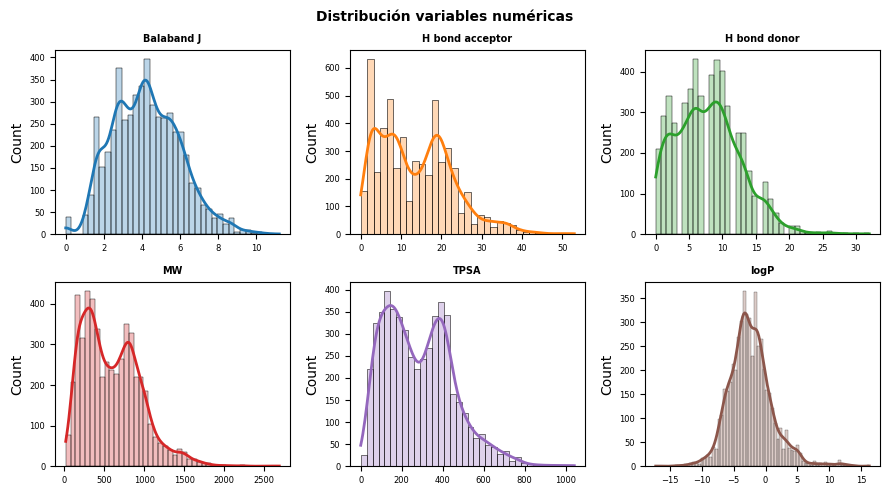

In [11]:
# Grafic de distribució per cada variable numèrica.
import seaborn as sns

# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data     = df,
        x        = colum,
        stat     = "count",
        kde      = True,
        color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws = {'linewidth': 2},
        alpha    = 0.3,
        ax       = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold")

# Dividim les dades en train i test

Avaluar la capacitat predictiva d'un model consisteix en comprovar com de pròximes són les seves prediccions als vertaders valors de la variable resposta. Per poder quantificar-lo de forma correcte, es necessita disposar d'un conjunt d'observacions, de les que es conegui la variable resposta, però que no hagin participat en el seu ajust. És per això que es divideixen les dades disponibles en un conjunt d'entrenament i un conjunt test. La mida adequada de les particions depèn de la quantitat de dades disponibles, en aquest cas utilitzarem 80% i 20%. La divisió es genera de forma aleatòria-estratificat.

És important verificar que la distribució de la variable resposta és semblant en el conjunt d'entrenament i en el conjunt test. Per assegurar que això és així, la funció train_test_split() de scikit-learn, permet identificar amb l'argument stratify la variable per fer un repartiment equitatiu en ambdós grups. 



In [16]:
input="data/RF.csv"
df = pd.read_csv(input, sep=",")

# Reparto de datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop('ECNumber', axis = 'columns'),
                                        df['ECNumber'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True,
                                        stratify=df['ECNumber'],
                                    )



y_train_counts = y_train.value_counts()
y_train_proportions = y_train.value_counts(normalize=True)

print(y_train_counts)
print(y_train_proportions)

1    1672
2     994
3     926
4     303
6     143
5     120
7      18
Name: ECNumber, dtype: int64
1    0.400383
2    0.238027
3    0.221743
4    0.072557
6    0.034243
5    0.028736
7    0.004310
Name: ECNumber, dtype: float64


In [15]:
y_test_counts = y_test.value_counts()
y_test_proportions = y_test.value_counts(normalize=True)

print(y_test_counts)
print(y_test_proportions)

1    418
2    249
3    231
4     75
6     36
5     30
7      5
Name: ECNumber, dtype: int64
1    0.400383
2    0.238506
3    0.221264
4    0.071839
6    0.034483
5    0.028736
7    0.004789
Name: ECNumber, dtype: float64


Veiem que hi ha la mateixa propurció dels diferents grups de classificació d'ECNumbers en els dos grups, test i train. Per exemple, tenim un 40,03% de ECNumbers del grup 1 i un 23,85% d'ECNumbers corresponents al grup 2. Trobem els mateixos valors tant en el conjunt de test com en el conjunt de train.

## Preprocessat

El preprocessat consta de totes aquelles tranformacions fetes sobre les dades amb l'objectiu de poder ser interpretades per l'algoritme de _machine learning_ de la manera més eficient possible. El preprocessat s'ha de fer amb el conjunt d'entrenament i després aplicar-se en el conjunt de test. Això és important per tal que cap informació procedent de les observacions de test influeixin en l'ajust del model. 

Seguidament utilizem el codi StandardScaler per estandaritzar les varibales numèriques en els conjunts d'entrenament i test. Aquesta estandarització ajuda a garantitzar que les veriables tinguin una escala comparable i estiguin centrades al voltant del zero abans d'entrenar el model. 

In [ ]:
# Feature Scaling
scaler = StandardScaler() #es crea l'objecte scaler que s'utilitza per estandaritzar les característiques, ajuda a evitar biaixos
X_train = scaler.fit_transform(X_train) #s'ajusta i transforma les variables numèriques en el conjunt d'entrenament. 
X_test = scaler.transform(X_test)#es transformen les característiques del conjunt test. transform aplica la mateixa transformació que en les dades d'entrenament. Aixó assegura que les variables de test s'estandaritzin de la mateixa manera.


## Creació dels models.

# Random Forest



In [116]:
# Fitting Random Forest Classification to the Training set
rf=classifier = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 100)
rf.fit(X_train, y_train)



RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=100)

In [117]:
y_pred = rf.predict(X_test)

In [118]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8237547892720306


# Error del test

In [133]:
# mean_squared_error de test
# ==============================================================================
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(
        y_true = y_test,
        y_pred = y_pred,
        squared = False
       )
rmse

0.9529144646879353

In [129]:
from sklearn.metrics import classification_report

# Supongamos que tienes el modelo entrenado y los datos de prueba
y_pred = rf.predict(X_test)

# Calcular el reporte de clasificación
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           1       0.86      0.93      0.89       408
           2       0.78      0.75      0.76       229
           3       0.85      0.95      0.90       248
           4       0.67      0.43      0.53        81
           5       0.62      0.50      0.55        32
           6       0.88      0.56      0.69        41
           7       0.00      0.00      0.00         5

    accuracy                           0.82      1044
   macro avg       0.67      0.59      0.62      1044
weighted avg       0.81      0.82      0.81      1044



## Visualització dels resultats

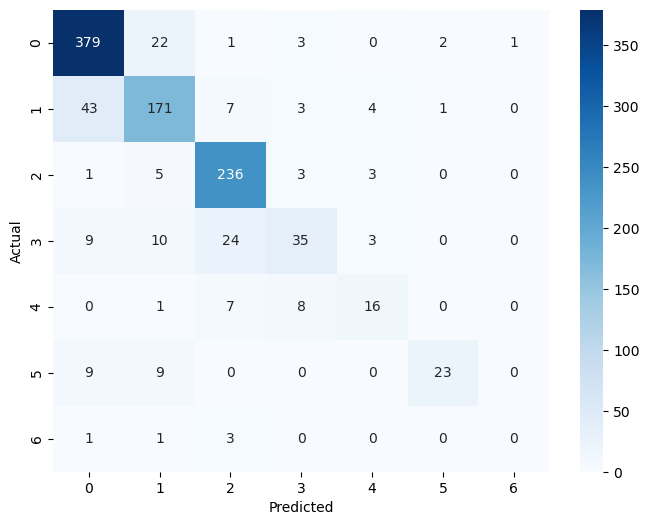

In [119]:
# Obtener la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [130]:
from sklearn.metrics import classification_report

# Generar el informe de clasificación
report = classification_report(y_test, y_pred)

# Imprimir el informe de clasificación
print(report)

              precision    recall  f1-score   support

           1       0.86      0.93      0.89       408
           2       0.78      0.75      0.76       229
           3       0.85      0.95      0.90       248
           4       0.67      0.43      0.53        81
           5       0.62      0.50      0.55        32
           6       0.88      0.56      0.69        41
           7       0.00      0.00      0.00         5

    accuracy                           0.82      1044
   macro avg       0.67      0.59      0.62      1044
weighted avg       0.81      0.82      0.81      1044



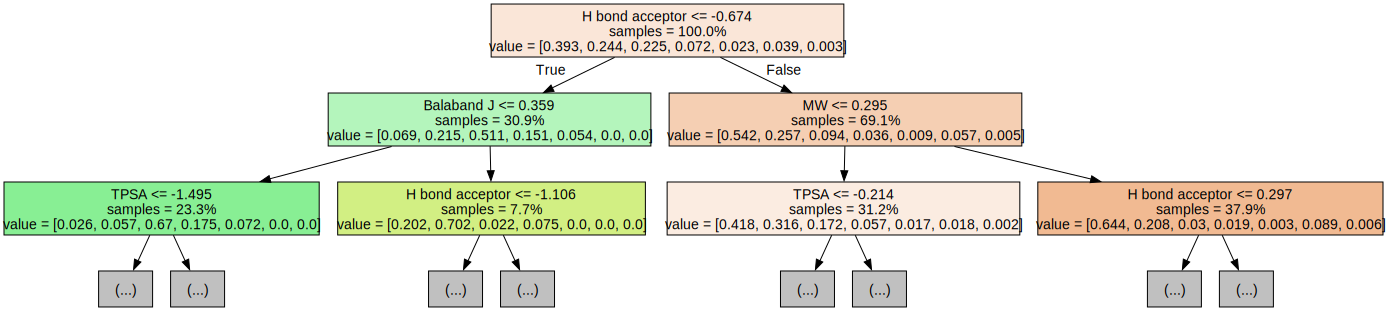

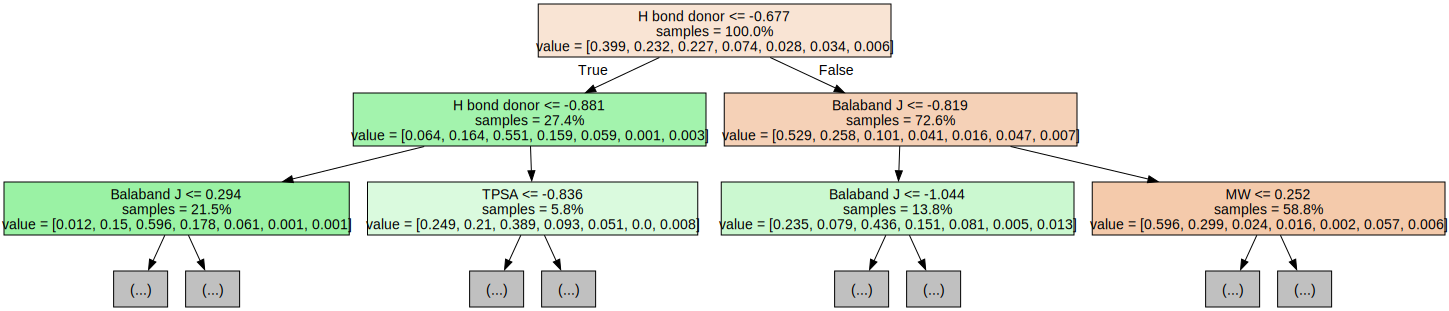

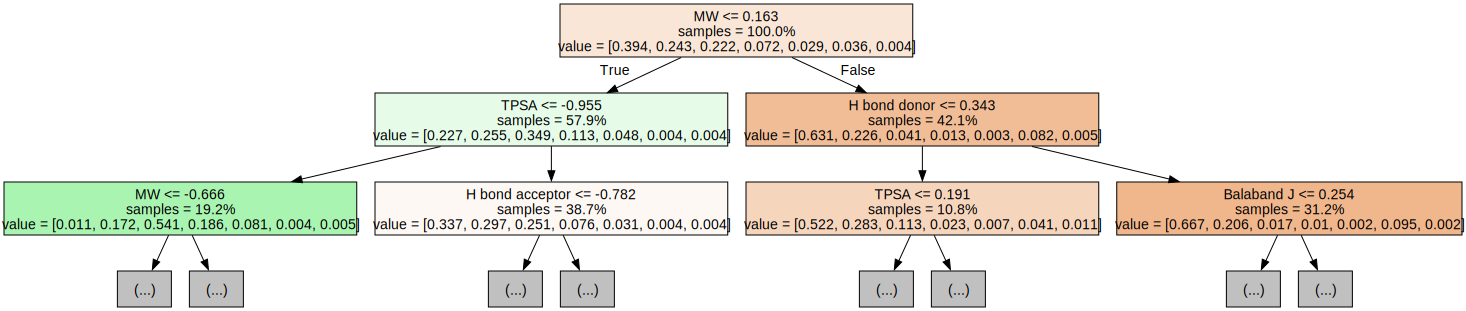

In [70]:
# Export the first three decision trees from the forest
# Convert X_train to a DataFrame
X_train_df = pd.DataFrame(X_train, columns=["Balaband J", "H bond acceptor", "H bond donor", 'MW', 'TPSA','logP',])

# Export the first three decision trees from the forest
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


# K-NN 

In [134]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [136]:


X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop('ECNumber', axis = 'columns'),
                                        df['ECNumber'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )



NameError: name 'head' is not defined

In [153]:
k = 3  # Número de vecinos a considerar
classifier = KNeighborsClassifier(n_neighbors=k)

In [154]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [155]:
y_pred = classifier.predict(X_test)

In [156]:
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)

Precisión: 0.6580459770114943


# Gradient Boosting Trees

In [157]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Separar las características (X) y las etiquetas (y)
X = df.drop('ECNumber', axis=1)
y = df['ECNumber']

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de Gradient Boosting Trees
model = GradientBoostingClassifier()

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)


Precisión del modelo: 0.7854406130268199
